In [91]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import os
from parameter_setup import normalization
import time
from PIL import Image
from scipy.signal import find_peaks
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from scipy.interpolate import RegularGridInterpolator
from matplotlib.ticker import FuncFormatter
from math import ceil, log
from pyargus.directionEstimation import *
from scipy.constants import c

In [92]:
def load_params(data_folder):
    parameters = {}
    parameters['start_freq'] = np.load(f'./{data_folder}/parameters/start_freq.npy')
    parameters['stop_freq'] = np.load(f'./{data_folder}/parameters/stop_freq.npy')
    parameters['num_freq_step'] = np.load(f'./{data_folder}/parameters/num_freq_step.npy')
    parameters['rbw'] = np.load(f'./{data_folder}/parameters/rbw.npy')
    parameters['TxRxPairs'] = np.load(f'./{data_folder}/parameters/TxRxPairs.npy')
    parameters['freq'] = np.load(f'./{data_folder}/parameters/freq.npy')
    parameters['dist_vec'] = np.load(f'./{data_folder}/parameters/dist_vec.npy')
    parameters['AoD_vec'] = np.load(f'./{data_folder}/parameters/AoD_vec.npy')
    parameters['AoA_vec'] = np.load(f'./{data_folder}/parameters/AoA_vec.npy')
    parameters['doppler_freq'] = np.load(f'./{data_folder}/parameters/doppler_freq.npy')
    parameters['range_Nfft'] = np.load(f'./{data_folder}/parameters/range_Nfft.npy')
    parameters['angle_Nfft'] = np.load(f'./{data_folder}/parameters/angle_Nfft.npy')
    parameters['doppler_Nfft'] = np.load(f'./{data_folder}/parameters/doppler_Nfft.npy')
    parameters['x_offset_shift'] = np.load(f'./{data_folder}/parameters/x_offset_shift.npy')
    parameters['y_offset_shift'] = np.load(f'./{data_folder}/parameters/y_offset_shift.npy')
    parameters['x_ratio'] = np.load(f'./{data_folder}/parameters/x_ratio.npy')
    parameters['y_ratio'] = np.load(f'./{data_folder}/parameters/y_ratio.npy')
    parameters['ant_loc'] = np.load(f'./{data_folder}/parameters/ant_loc.npy')
    parameters['doppler_window_size'] = np.load(f'./{data_folder}/parameters/doppler_window_size.npy')
    parameters['cal_arr'] = np.load(f'./{data_folder}/parameters/cal_arr.npy')

    return parameters

def filter_and_cluster(matrix, threshold=0.0, n=np.inf, eps=1, min_samples=3):
    indices = np.argwhere(matrix > threshold)

    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(indices)
    labels = clustering.labels_
    unique_labels = np.unique(labels)

    cluster_sizes = [(label, sum(labels == label)) for label in unique_labels if label != -1]
    cluster_sizes.sort(key=lambda x: x[1], reverse=True)

    selected_indices = []
    for i in range(min(n, len(cluster_sizes))):
        label = cluster_sizes[i][0]
        cluster_indices = indices[labels == label]
        centroid = cluster_indices.mean(axis=0)
        selected_indices.append(cluster_indices[distance.cdist([centroid], cluster_indices).argmin()])

    return np.array(selected_indices)

# Conversion function
def spherical_to_rectangular(r, theta, phi):
    theta = np.radians(theta)
    phi = np.radians(phi)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

def count_occupants(xy_projection, grid_x, grid_y, thres=0.03, eps=1, n=np.inf):
    x_axis = np.linspace(grid_x.min(), grid_x.max(), 64)
    y_axis = np.linspace(grid_y.min(), grid_y.max(), 64)

    occupancy_map = np.array([False, False, False, False])

    peak_indices = filter_and_cluster(normalization(xy_projection), threshold=thres, eps=eps, n=n)
    peak_locs = []
    for idx in peak_indices:
        peak_locs.append((x_axis[idx[0]], y_axis[idx[1]]))
    peak_locs = np.array(peak_locs)

    if np.any(np.logical_and(peak_locs[:,0]<0, peak_locs[:,1]<0)):
        occupancy_map[0] = True
        print('Seat #1 Occupied')
    if np.any(np.logical_and(peak_locs[:,0]>=0, peak_locs[:,1]<0)):
        occupancy_map[1] = True
        print('Seat #2 Occupied')
    if np.any(np.logical_and(peak_locs[:,0]<0, peak_locs[:,1]>=0)):
        occupancy_map[2] = True
        print('Seat #3 Occupied')
    if np.any(np.logical_and(peak_locs[:,0]>=0, peak_locs[:,1]>=0)):
        occupancy_map[3] = True
        print('Seat #4 Occupied')

    n_occupants = len(peak_indices)
    print(f'There are {n_occupants} occupants in the vehicle.')
    return n_occupants, occupancy_map, peak_indices

In [93]:
test_file_list = ['2p_seat_12_rbw_100_06-26-2023--19-54-06', 
                  '2p_seat_12_rbw_100_06-26-2023--19-54-06', 
                  '2p_seat_14_rbw_100_06-26-2023--20-12-36', 
                  '1p_seat_3_rbw_100_06-26-2023--19-32-26']

In [94]:
collected_data_folder = './collected_data'
   
data = test_file_list[0]
file_name = data
# plt.title(f'Experiment: {data}')
cur_frame = 100

data_folder = os.path.join(collected_data_folder,data)

# Setup the data path
data_queue_folder = os.path.join(data_folder, 'data_queue')
data_queue = sorted(os.listdir(data_queue_folder)) 

# load parameters
params = load_params(data_folder)
vmin = 0.0#6
ntarget = 100
thres=0.8
eps=10
n=2
enhance_rate = 1
bound = 3
n_antenna = 4
choose_center = False
time_window_len = 5
cal_frame_len = 5
if time_window_len < cal_frame_len:
    time_window_len = cal_frame_len
if choose_center:
    ants_loc = 'center'
else:
    ants_loc = 'front'
n_target = data[0]
cur_folder_name = f'{n_target}p_with_cf_{n_antenna}x{n_antenna}_antenna_{ants_loc}'
if cur_folder_name not in os.listdir('./processed_data_plots'):
    os.mkdir(f'./processed_data_plots/{cur_folder_name}')
cur_fig_name = f'./processed_data_plots/{cur_folder_name}/{file_name}.jpg'
# Record the starting time
start = time.time()
# cal_frame = params['cal_arr']
# cal_arr = cal_frame[len(cal_frame)//2]#np.mean(cal_frame, axis=0)
data_arr = []
for cur_frame_data in data_queue:
    # cur_frame_data = data # data_queue[cur_frame]
    data_arr.append(np.load(os.path.join(data_queue_folder,cur_frame_data)))
rec_arr = data_arr[cur_frame]#np.mean(np.array(data_arr), axis=0)
data_arr = np.stack(data_arr,axis=0)
# cal_frame = data_arr[cur_frame-time_window_len:cur_frame-time_window_len+cal_frame_len]
# music_cal_frame = np.mean(cal_frame, axis=0)
# cal_frame = np.fft.ifft(cal_frame, n=params['range_Nfft'], axis=2)
cal_frame = np.mean(data_arr[:5,:,:], axis=0)

In [95]:
from pyargus.directionEstimation import *
def compute_tof_scanning_vector(freq, time_vec):
    # Compute the scanning vector
    df = freq[1] - freq[0]
    freq_shift = np.arange(0,len(freq))
    freq_shift =  df*freq_shift
    scanning_vectors = np.zeros((len(freq),len(time_vec)),dtype='complex')
    for i in range(len(time_vec)):
        scanning_vectors[:,i] = np.exp(-1j*2*np.pi*freq_shift*time_vec[i])
    # scanning_vectors = np.real(scanning_vectors)
    # scanning_vectors = np.exp(1j*2*np.pi*time_vec).reshape(-1,1)
    return scanning_vectors


def compute_tof_music(test_signal, scanning_vectors, dist_vec, signal_dimension=3, plot=False):
    # test_signal = test_signal.reshape(-1,1)

    # Compute the correlation matrix
    # R = np.dot(test_signal, test_signal.conj().T)
    P = 150
    R = spatial_smoothing(test_signal, P=P, direction="forward-backward")

    # Implement MUSIC for ToF
    tof = np.zeros(np.size(scanning_vectors, 1))
    M = np.size(R, 0)

    # --- Calculation ---
    # Determine eigenvectors and eigenvalues
    sigmai, vi = lin.eig(R)
    # Sorting    
    eig_array = []
    for i in range(M):
        eig_array.append([np.abs(sigmai[i]),vi[:,i]])
    eig_array = sorted(eig_array, key=lambda eig_array: eig_array[0], reverse=False)

    # Generate noise subspace matrix
    noise_dimension = M - signal_dimension    
    E = np.zeros((M,noise_dimension),dtype=complex)
    for i in range(noise_dimension):     
        E[:,i] = eig_array[i][1]     
        
    E = np.matrix(E)    
    theta_index=0
    for i in range(np.size(scanning_vectors, 1)):             
        S_theta_ = scanning_vectors[:, i]
        S_theta_  = np.matrix(S_theta_).getT() 
        tof[theta_index]=  1/np.abs(S_theta_.getH()*(E*E.getH())*S_theta_)
        theta_index += 1

    log_scale_min = -50

    tof = np.divide(np.abs(tof),np.max(np.abs(tof))) # normalization 
    tof = 10*np.log10(tof)                
    time_index = 0        
    for t in time_vec:                    
        if tof[time_index] < log_scale_min:
            tof[time_index] = log_scale_min
        time_index += 1   
    # tof = normalization(np.abs(tof))
    tof = normalization(tof-np.min(tof))
    if plot:
        plt.figure()
        axes = plt.axes()
        axes.plot(dist_vec,tof)    
        axes.set_title('ToF MUSIC estimation ',fontsize = 16)
        axes.set_xlabel('Range [m]')
        axes.set_ylabel('Amplitude [dB]')   
        axes.legend(["MUSIC"])
    # print(tof)
    return tof

# Extract the data of the first TxRx pair in the first frame
test_signal = data_arr[100,:,:]#-cal_arr
test_signal = test_signal#[10,:]
Ts = 1/len(params['freq'])/(params['freq'][1]-params['freq'][0]+1e-16)
time_vec = np.linspace(0,Ts*(len(params['freq'])-1),num=len(params['freq']))
dist_vec = time_vec*(c/2)
scanning_vectors = compute_tof_scanning_vector(params['freq'],time_vec)
test_tof = compute_tof_music(test_signal=test_signal, scanning_vectors=scanning_vectors, dist_vec=dist_vec, signal_dimension=10,plot=False)
print(dist_vec[np.argmax(test_tof)])

1.5102401894181263


Text(0, 0.5, 'Magnitude')

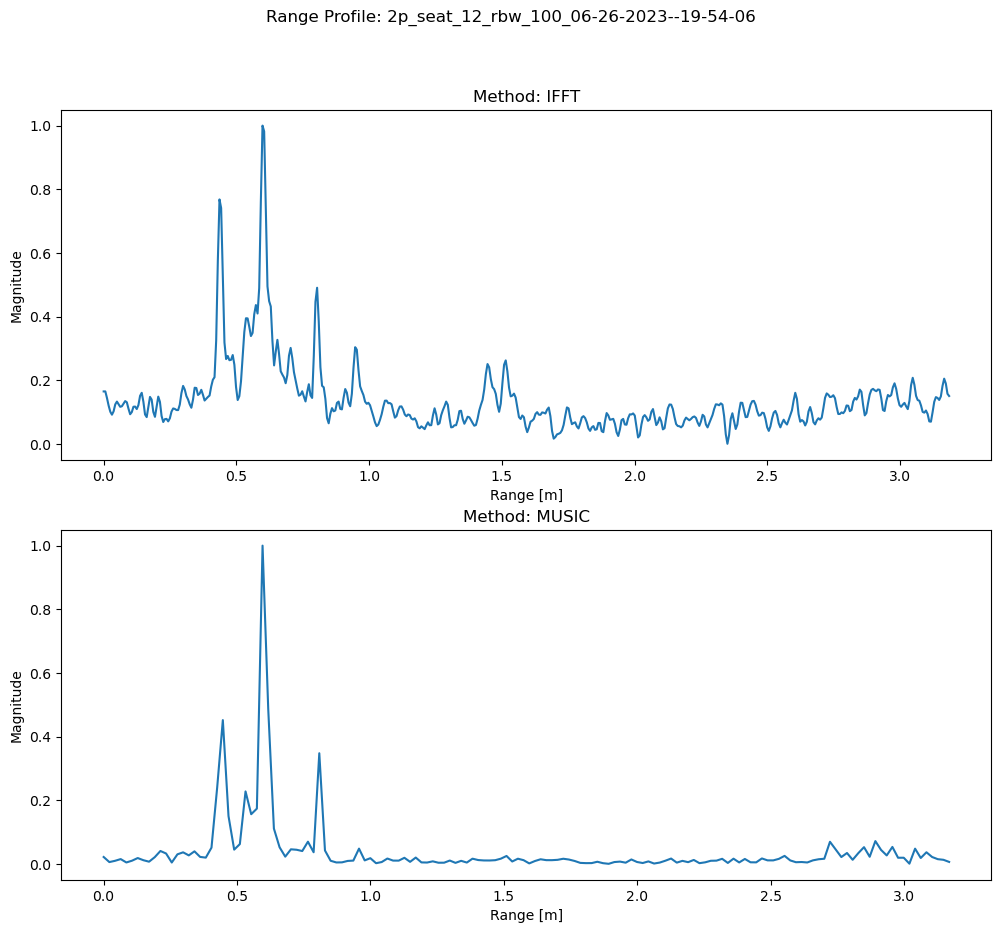

In [96]:
range_profile_ifft = np.fft.ifft(data_arr[100]-cal_frame,n=params['range_Nfft'],axis=1)#-cal_frame

range_profile_ifft = normalization(np.linalg.norm(range_profile_ifft,axis=0))


test_signal = data_arr[100,:,:] - cal_frame
test_signal = test_signal
scanning_vectors = compute_tof_scanning_vector(params['freq'],time_vec)
range_profile_music = compute_tof_music(test_signal=test_signal, scanning_vectors=scanning_vectors, dist_vec=dist_vec, signal_dimension=6,plot=False)

fig, axs = plt.subplots(2,figsize=(12,10))
fig.suptitle(f'Range Profile: {data}')
axs[0].plot(params['dist_vec'],range_profile_ifft)
axs[0].set_title('Method: IFFT')
axs[0].set_xlabel('Range [m]')
axs[0].set_ylabel('Magnitude')
axs[1].plot(dist_vec,range_profile_music)
axs[1].set_title('Method: MUSIC')
axs[1].set_xlabel('Range [m]')
axs[1].set_ylabel('Magnitude')

### Angle MUSIC

(20, 20, 150)
(20, 150)


<AxesSubplot:title={'center':'Direction of Arrival estimation '}, xlabel='Incident angle [deg]', ylabel='Amplitude [dB]'>

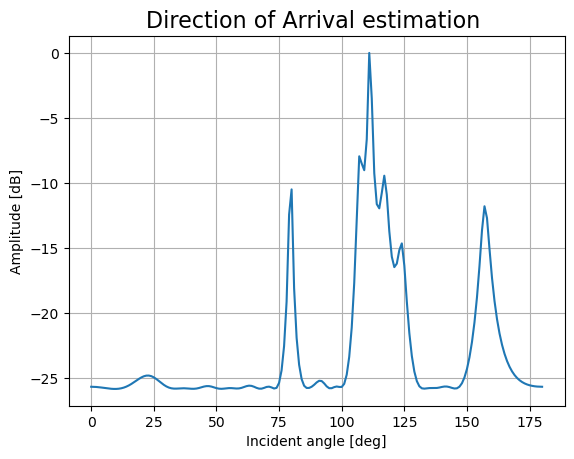

In [102]:
rec_signal = (data_arr[100] - cal_frame).reshape(20,20,-1)
print(rec_signal.shape)
test_signal = rec_signal[10,:,:]
print(test_signal.shape)
P = 20
d = 0.5
R_ss = spatial_smoothing(test_signal, P=20, direction="forward-backward")

array_alignment = np.arange(0,P,1)*d
incident_angles = np.arange(0,181,1)
aoa_scanning_vectors = gen_ula_scanning_vectors(array_alignment,incident_angles)

MUSIC = DOA_MUSIC(R_ss, scanning_vectors, signal_dimension = 6)
axes = plt.axes()
DOA_plot(MUSIC, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)




In [ ]:

def tof_aoa_MUSIC(R, array_alignment, signal_dimension, coherent_sources=2, angle_resolution = 1,):
    """                                 
                    MD-MUSIC - Multi Dimensional Multiple Signal Classification method

        
        
         Description:
         ------------    
           The function implements the MD-MUSIC method for direction estimation
           
           Calculation method : 
        
                                                    1
                        ADORT(theta) = ---------------------------
                                            H H       H 
                                           A*c * En En  * A c 
                                           
                        A  - Array response matrix
                        C  - Liner combiner vector
                        En - Noise subspace matrix
           
        Implementation notes:
        ---------------------
        
            This function works only for two coherent signal sources. Note that, however the algorithm works
            for arbitrary number of coherent sources, the computational cost increases exponentially, thus
            using this algorithm for higher number of sources is impractical.
        
        Parameters:
        -----------                
         
            :param R: spatial correlation matrix
            :param array_alignment : Array containing the antenna positions measured in the wavelength             
            :param signal_dimension: Number of signal sources    
            :param coherent_sources: Number of coherent sources
            :param angle_resolution: Angle resolution of scanning vector s(theta) [deg] (default : 1)
           
            :type R: 2D numpy array with size of M x M, where M is the number of antennas in the antenna system                            
            :tpye array_alignment: 1D numpy array with size: M x 1 
            :type signal_dimension: int
            :type: coherent_sources: int
            :type angle_resolution: float      
   
       Return values:
       --------------
       
            :return  ADORT : Angular dependent orthogonality. Expresses the orthongonality of the current steering vector to the 
                    noise subspace
            :rtype : L dimensional numpy array, where L is the number of coherent sources
         
            :return -1, -1: Input spatial correlation matrix is not quadratic
            :return -2, -2: dimension of R not equal with dimension of the antenna array 
            
    """
    
    # --- Parameters ---  
    
    # --> Input check
    if np.size(R, 0) != np.size(R, 1):
        print("ERROR: Correlation matrix is not quadratic")
        return -1, -1
    
    if np.size(R, 0) != np.size(array_alignment, 0):
        print("ERROR: Correlation matrix dimension does not match with the antenna array dimension")
        return -2, -2                

    incident_angles = np.arange(0,180+angle_resolution,angle_resolution)
    ADORT = np.zeros((int(180/angle_resolution+1), int(180/angle_resolution+1)), dtype=float)
                     
    M = np.size(R, 0) # Number of antenna elements
    
    # --- Calculation ---
    # Determine eigenvectors and eigenvalues
    sigmai, vi = lin.eig(R)
    # Sorting    
    eig_array = []    
    for i in range(M):
        eig_array.append([np.abs(sigmai[i]),vi[:,i]])
    eig_array = sorted(eig_array, key=lambda eig_array: eig_array[0],
                       reverse=False)    
   
    # Generate noise subspace matrix
    noise_dimension = M - signal_dimension    
    E = np.zeros((M,noise_dimension),dtype=complex)
    for i in range(noise_dimension):     
        E[:,i] = eig_array[i][1]
           
    E = np.matrix(E)   
    
    theta_index  = 0
    theta2_index = 0
    
         
    for theta in incident_angles:                
        S_theta_  = np.exp(array_alignment*1j*2*np.pi*np.cos(np.radians(theta))) # Scanning vector      
        theta2_index=0
        for theta2 in incident_angles[0:theta_index]:            
            S_theta_2_ = np.exp(array_alignment*1j*2*np.pi*np.cos(np.radians(theta2))) # Scanning vector                                  
            a = np.matrix(S_theta_+S_theta_2_).getT() # Spatial signiture vector
            ADORT[theta_index,theta2_index]=  np.real(1/np.abs(a.getH()*(E*E.getH())*a))            
            theta2_index += 1
        theta_index += 1
    
    return ADORT, incident_angles

(20, 150)
(150, 150)
(20, 181)
(3000, 27150)
ERROR: Correlation matrix dimension does not match with the antenna array dimension


IndexError: index 2 is out of bounds for axis 0 with size 2

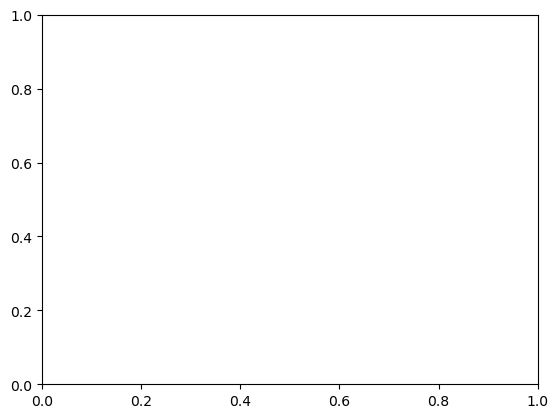

In [104]:
rec_signal = (data_arr[100] - cal_frame).reshape(20,20,-1)
test_signal = rec_signal[10,:,:]
print(test_signal.shape)
P = 20
d = 0.5
R_ss = spatial_smoothing(test_signal, P=20, direction="forward-backward")

array_alignment = np.arange(0,P,1)*d
incident_angles = np.arange(0,181,1)
aoa_scanning_vectors = gen_ula_scanning_vectors(array_alignment,incident_angles)
tof_scanning_vectors = compute_tof_scanning_vector(params['freq'], time_vec)

scanning_vectors = np.kron(tof_scanning_vectors, aoa_scanning_vectors)
print(tof_scanning_vectors.shape)
print(aoa_scanning_vectors.shape)
print(scanning_vectors.shape)

MUSIC = DOA_MUSIC(R_ss, scanning_vectors, signal_dimension = 6)
axes = plt.axes()
DOA_plot(MUSIC, incident_angles, log_scale_min = -50, axes=axes, alias_highlight=False)




### All Together

In [98]:
# # Define Parameters
# n_tx = 20
# n_rx = 20
# cur_frame = 100
# cal_frame = 5
# cal_arr = np.mean(data_arr[:cal_frame], axis=0)

# # Calibrate & Reshape Input Data
# test_signal = (data_arr[cur_frame] - cal_arr).reshape(n_tx, n_rx, -1)

# # Compute Range Profile
# scanning_vectors = compute_tof_scanning_vector(params['freq'],time_vec)
# range_profile_music = compute_tof_music(test_signal=test_signal, scanning_vectors=scanning_vectors, dist_vec=dist_vec, signal_dimension=6,plot=False)